In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Deadlock

A deadlock occurs when a set of blocked processes each holds a resource and are waiting to acquire a resource held by another process in the set.

## Physical examples

### Bridge crossing

Suppose that there is a narrow bridge which only 1 person can cross at a time.
Consider the situation where a person goes onto the bridge on one end, and another on the other.
Both person want to cross the bridge, but are unable to as they are blocked by the other.

One way to resolve this is to have person A get off the bridge so that person B can cross, which clears the bridge for person A to cross.
This is akin to a process releasing a resource to avoid a deadlock situation.

### Dining philosophers

Suppose that there are 5 philosophers seating on a round table.
There are 5 individual chopsticks on the table, each between 2 philosophers.

Suppose that the philosophers are conditioned to try to obtain a pair of chopsticks.
Once it has a pair, it will consume his food, and return the chopsticks that he used back onto the table.

Now, consider the case where all 5 philosophers tries to obtain a chopstick, leading to a situation where each of the 5 has only 1 chopstick.
This result in none of them being able to proceed to consume food, and caused all of them to be waiting for a free chopstick to appear on the table.
This is also a deadlock situation.

## System model

To simplify our analysis of deadlocks, we model the system using a node and vertex graph.

In [2]:
G = nx.DiGraph()
G.add_node("R1", pos=(1, 2), n=1)
G.add_node("R2", pos=(3, 2), n=1)
G.add_node("R3", pos=(1, 0), n=2)
G.add_node("P1", pos=(0, 1))
G.add_node("P2", pos=(2, 1))
G.add_node("P3", pos=(4, 1))
G.add_edge("R1", "P2")
G.add_edge("R2", "P3")
G.add_edge("R3", "P1")
G.add_edge("R3", "P2")
G.add_edge("P1", "R1")
G.add_edge("P2", "R2")

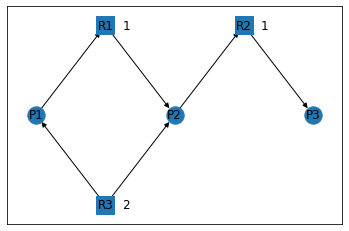

In [3]:
def plot_graph(G):
    pos = nx.get_node_attributes(G, "pos")
    nx.draw_networkx_nodes(G, pos, node_shape="o")
    nx.draw_networkx_nodes(
        G, pos, node_shape="s", nodelist=[v for v in pos if "R" in v]
    )
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(
        G,
        {v: (p[0] + 0.3, p[1]) for v, p in pos.items()},
        labels=nx.get_node_attributes(G, "n"),
    )
    nx.draw_networkx_labels(G, pos)
    plt.show()


plot_graph(G)

These are the characteristics of the graph:
* Resource: square nodes
* Processes: round nodes
* Capacity of the resource: number to the right of the resource
* Request of resource: edge from a process to a resource
    * When the request is granted, the edge is removed
* Assignment of resource: edge from a resource to a process
    * When resource is released, the edge is removed


In the above graph, the following sequence will happen:
1. $P3$ will complete
2. $P3$ releases $R2$
3. $R2$ gets assigned to $P2$
4. $P2$ can now complete
5. $P2$ releases $R1$ and $R3$
6. When $P2$ releases $R1$, it can now be allocated to $P1$ and thus $P1$ can now complete

Hence, there is no deadlock in the graph above.

Now consider this modified graph.

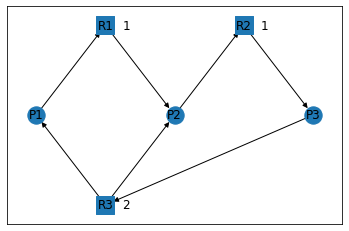

In [4]:
G.add_edge("P3", "R3")

plot_graph(G)

Now, $P3$ cannot complete as it is unable to obtain $R3$ since both instances are assigned to $P1$ and $P2$.
In fact, none of the 3 process can complete, and hence this is a deadlock.

From the graph, we see that _if a deadlock occurs, there is a cycle in the system graph_.
Try convincing yourself this fact.

However, **this is not a sufficient condition**, because there can be a graph which has a cycle, but is not in deadlock, as per below:

In [5]:
G = nx.DiGraph()
G.add_node("R1", pos=(1, 2), n=2)
G.add_node("R2", pos=(1, 0), n=1)
G.add_node("P1", pos=(0, 1))
G.add_node("P2", pos=(2, 1))
G.add_node("P3", pos=(3, 2))
G.add_edge("R1", "P2")
G.add_edge("R1", "P3")
G.add_edge("R2", "P1")
G.add_edge("P1", "R1")
G.add_edge("P2", "R2")

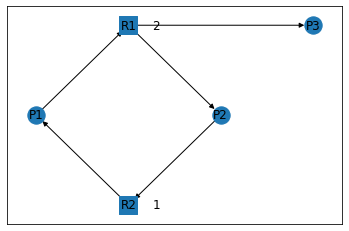

In [6]:
plot_graph(G)

Despite the $P1 \rightarrow R1 \rightarrow P2 \rightarrow R2 \rightarrow P1$ cycle, the system is not in deadlock.

The following resolution sequence will occur:
1. $P3$ completes
2. $P3$ releases $R1$
3. $P1$ obtains $R1$
4. $P1$ completes
5. $P1$ releases $R2$
6. $P2$ obtains $R2$
7. $P2$ completes

Hence, this brings us to the inspiration for some basic indicators of deadlocks

## Indicators of deadlocks

* If the graph contains no cycles, there is **no deadlocks**
* If the graph contains a cycle:
    * and only 1 instance per resource type in that cycle, then there **is a deadlock**
    * but there are several instances per resource type in that cycle, then there **may be a deadlock**

## Conditions for deadlock

For a deadlock to occur, the following 4 condition must be true

* **Mutual exclusion**: only 1 process can use the resource at any time
* **Hold and wait**: a process is holding onto some resource while waiting to obtain additional resources held by other processes
* **No preemption**: a resource can only be released voluntarily by the process holding it
* **Circular wait**: there is a cycle of processes that are waiting for resource
    * _ie_ there is a cycle in our system graph

## Solutions for deadlocks

* Ensure that the system will never enter a deadlock
* Allow the system to enter deadlock, and have some recovery mechanism
* Assume that deadlock never occurs in the system
    * Practiced by many common OS's, including UNIX

## Prevention of deadlocks

By failing to satisfy any of the conditions for a deadlock, we can avoid deadlocks all together.

Hence, the below are the ways to violate each of the conditions:
* **Mutual exclusion**: allowing simultaneous use of resources
    * Easy to satisfy if all resources are shareable, but this is usually not the case
    * _eg_ Dining philosophers are trying to browse 5 different menus. All 5 of them can be viewing any of the menu at the same time, hence there is no deadlock.
* **Hold and wait**: when a process requests a resource, it must not hold onto other resources
    * _eg_ Philosophers only pick up a chopstick if there are 2 chopsticks available
* **No preemption**: If a process is holding some resources that cannot be allocated in time, then all resources current held by it is released.
    * _eg_ Philosophers releases their chopstick if they cannot get another chopstick after some time
* **Circular wait**: Prevent cycles in our system graph
    * _ie_ Allow at most 4 philosophers to be active at any given time

## Deadlock avoidance

The deadlock avoidance algorithm dynamically examines resource allocation to ensure that the system never enters an unsafe state.
When a process requests for a resource, the system must decide if it should allocate the resource to the process, or ask the process to wait.

The system is in a safe state if there exists some safe sequence for all processes.
*When a system is safe, no deadlocks can occur*.

Given some sequence $P_1, P_2 \dots P_n$, the sequence is safe if for each process $P_i$, the resources it needs can be satisfied by the available resource currently together with the resources held by all $P_j$'s, with $j < i$.

In other words, when all $P_j$ completes, $P_i$ must have the resources it needs to run.

### Example

Consider the system with 3 processes, 1 resource with **the current capacity of 1**:

| Process | Hold | Request |
| --- | --- | --- |
| P1 | 1 | 1 |
| P2 | 1 | 2 |
| P3 | 1 | 3 |

Consider the sequence $P1, P2, P3$.

1. $P1$ obtains the currently available resource
2. $P1$ completes
3. $P1$ releases its resource
4. Current resource = 2
1. $P2$ obtains the currently available resource
2. $P2$ completes
3. $P2$ releases its resource
4. Current resource = 3
1. $P3$ obtains the currently available resource
2. $P3$ completes
3. $P3$ releases its resource

Hence, the sequence is safe

---

Now, consider the sequence of $P3, P2, P1$.
Since $P3$ cannot complete due to insufficient resources, this sequence is not safe.

Since the system has a safe sequence of $P1, P2 ,P3$, the system is safe.

### Banker's algorithm

The *Banker's algorithm* allows us to check if a system is safe.

The following are the notations for the algorithm:
* `n`: number of processes
* `m`: number of resource types
* `Available`: array of size `m`, where `Available[i] = k` indicates that there are `k` available instances of resource `i`
* `Max`: array of size `n x m`, where `Max[i][j] = k` indicates that process `i` will request at most `k` instance of resource `j`
* `Allocation`: array of size `n x m`, where `Allocation[i][j] = k` indicates that `k` instances of resource `j` is being allocated to process `i`
* `Need`: array of size `n x m`, where `Need[i][j] = k` indicates that process `i` needs indicates `k` more instances of resource `j` to complete
    * `Need = Max - Allocation`

The algorithm is as follows:
1. Set `Work = Available`
2. Set `Finish` to be an array of size $n$, all of which are `false`
3. Find an `i` such that `Finish[i] == false` and `Need[i][j] = Work[j]` for all `j`
    * if no `i` exists, jump to step 5
4. Set `Work = Work + Allocation[i]` and `Finish[i] = true`
     * Go to step 2
5. If `Finish` is all `true`, then the system is safe, otherwise it is unsafe.

In [7]:
from dataclasses import dataclass, field


@dataclass
class System:
    allocation: np.ndarray
    maxes: np.ndarray
    available: np.ndarray
    need: np.ndarray = field(init=False)

    def __post_init__(self):
        self.need = self.maxes - self.allocation


def banker(system):
    assert system.allocation.shape == system.maxes.shape
    assert system.available.size == system.maxes.shape[1]

    n = system.maxes.shape[0]

    work = system.available.copy()
    finish = np.full(n, False)

    seq = []
    while True:
        has_needs = (system.need <= np.tile(work, (n, 1))).all(axis=1)
        arr = np.argwhere(np.logical_and(has_needs, np.logical_not(finish))).ravel()

        if not arr.size:
            break

        i = arr[0]
        work = work + system.allocation[i]
        finish[i] = True
        seq.append(i)

    is_safe = np.all(finish)
    return is_safe, seq if is_safe else []

For completion, we can check the "safe-ness" of our [previous example graphs](#System-model).

In [8]:
available = np.array([0, 0, 0])
allocation = np.array(
    [
        [0, 0, 1],
        [1, 0, 1],
        [0, 1, 0],
    ]
)

maxes = np.array(
    [
        [1, 0, 1],
        [1, 1, 1],
        [0, 1, 0],
    ]
)

system = System(allocation, maxes, available)
banker(system)

(True, [2, 1, 0])

In [9]:
available = np.array([0, 0, 0])
allocation = np.array(
    [
        [0, 0, 1],
        [1, 0, 1],
        [0, 1, 0],
    ]
)

maxes = np.array(
    [
        [1, 0, 1],
        [1, 1, 1],
        [0, 1, 1],
    ]
)

system = System(allocation, maxes, available)
banker(system)

(False, [])

In [10]:
available = np.array([0, 0])
allocation = np.array(
    [
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
    ]
)

maxes = np.array(
    [
        [1, 1],
        [1, 1],
        [0, 1],
        [1, 0],
    ]
)

system = System(allocation, maxes, available)
banker(system)

(True, [2, 1, 0, 3])

Indeed, it aligns with our deadlock analysis for those graphs.

Here is another example system and the application of Banker's algorithm

In [11]:
available = np.array([3, 3, 2])
allocation = np.array(
    [
        [0, 1, 0],
        [2, 0, 0],
        [3, 0, 2],
        [2, 1, 1],
        [0, 0, 2],
    ]
)

maxes = np.array(
    [
        [7, 5, 3],
        [3, 2, 2],
        [9, 0, 2],
        [2, 2, 2],
        [4, 3, 3],
    ]
)

system = System(allocation, maxes, available)
banker(system)

(True, [1, 3, 0, 2, 4])

Hence, with the Banker's algorithm, we can test if a system state is safe.

### Allocation decision

Suppose that a request for resources appears from a process.
Then we perform some basic checks:
* if request for any resource exceeds the needs, then we raise an error as a process exceeds its maximum claim
* if request for any resource exceeds the available, then we block the process as it needs to wait for the resource
* otherwise, we:
    * reduce `Available` by the request
    * increase `Allocation` by the request
    * recompute the `need`
    * then we perform the Banker's algorithm to check if the resultant system is safe
    * we allocate the resource to the process if and only if the resultant system is safe

In [12]:
def allocate(system: System, process: int, request: np.ndarray):
    request_arr = np.zeros(system.allocation.shape)
    request_arr[process] = request
    return System(
        allocation=system.allocation + request_arr,
        available=system.available - request,
        maxes=maxes,
    )


def should_allocate(system: System, process: int, request: np.ndarray):
    if np.any(request > system.need[process]):
        raise ValueError("Process request exceeds needs")

    if np.any(request > system.available[process]):
        return False

    result = allocate(system, process, request)
    is_safe, _ = banker(result)
    return is_safe

#### Example

Suppose that in the previous system, a request from $P_1$ occurs, for an additional `[1, 0, 2]` amount of resources.

In [13]:
should_allocate(system, 1, [1, 0, 2])

True

Using our allocation algorithm, we can see that we can allocate these resources to $P_1$ because the resultant system is safe.

Suppose that another request from $P_1$ occurs, for a further `[1, 0, 2]` amount of resources.

In [14]:
new_system = allocate(system, 1, [1, 0, 2])
should_allocate(new_system, 1, [1, 0, 2])

ValueError: Process request exceeds needs

The request is erroneous because the initial need is `[3, 2, 2] - [2, 0, 0] = [1, 2, 2]`.
After allocating the first `[1, 0, 2]`, the new need is `[1, 2, 2] - [1, 0, 2] = [0, 2, 0]`.
This means that the further request exceeds the maximum possible resource request for $R_0, R_2$.

---

Suppose that a request from $P_0$ occurs, for `[0, 2, 0]` amount of resources.

In [15]:
should_allocate(new_system, 0, [0, 2, 0])

False

Our decision algorithm see that allowing this request will cause the system to be unsafe, thus it postpone this allocation.